In [1]:
import numpy as np

loan_data = np.load("./balanced_loan_data.npy", allow_pickle=True)

/Users/mk/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
loan_data, loan_label, date = loan_data[:, :-2], loan_data[:, -2], loan_data[:, -1]

In [3]:
from sklearn.cluster import KMeans
import numpy as np



def initialize_parameters(
    n_components,
    n_features,
    first_points=None,
    method='random',
    random_state=None,
):
    # if random_state is not None:
    #     np.random.seed(random_state)

    # Step 1: Initialize mixing coefficients uniformly
    pi = np.ones(n_components) / n_components

    # Step 2: Initialize means
    if first_points is not None:
      if method == 'kmeans':
        #Use kmeans to initialize on a small batch, random initialization can lead to bad results
        kmeans = KMeans(n_clusters=n_components, init='k-means++', n_init=1, random_state=random_state)
        kmeans.fit(first_points)
        mu_k = kmeans.cluster_centers_
        #Add noise to mu_k
        mu_k = mu_k + np.random.randn(n_components, n_features) * 0.5
      elif method == 'random':
        # Random initialization based on the range observed from a small batch
        #init mu_k as an empty n_components,n_features shaped array
        mu_k = np.empty((n_components,n_features))
        for idx in range(n_features):
          mu_k[:,idx] = np.random.uniform(np.min(first_points[:,idx]), np.max(first_points[:,idx]), n_components)
    else:
        # Random initialization with large spread and mean 0
        mu_k = np.random.randn(n_components, n_features) * 5.0


    # Step 3: Initialize covariances with broad coverage
    # Use diagonal matrices with a slight spread for differentiation
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k)  # Increase spread slightly across components
        for k in range(n_components)
    ])

    return pi, mu_k, sigma_k



def compute_probabilities(x, pi, mu, sigma, eps=1e-15):
    K = len(pi)
    log_probabilities = np.zeros(K)

    for k in range(K):
        diff = x - mu[k]
        # Add small constant to diagonal for numerical stability
        sigma_k = sigma[k] + eps * np.eye(sigma[k].shape[0])

        # Compute log probability in a numerically stable way
        log_det = np.log(np.linalg.det(sigma_k))
        inv_sigma = np.linalg.inv(sigma_k)
        exponent = -0.5 * np.dot(diff.T, np.dot(inv_sigma, diff))
        log_probabilities[k] = np.log(pi[k]) + exponent - 0.5 * (log_det + len(x) * np.log(2 * np.pi))

    # Subtract maximum for numerical stability
    log_probabilities -= np.max(log_probabilities)
    probabilities = np.exp(log_probabilities)
    probabilities /= np.sum(probabilities)

    return probabilities

def compute_parameters(mu_stats, n_samples, reg_covar=1e-6, eps=1e-10):
    # Compute mixing coefficients with minimum probability
    pi = np.maximum(mu_stats['N'], eps)
    # pi = pi / np.sum(pi)
    pi = pi / n_samples

    # Compute means with safety check
    safe_N = np.maximum(mu_stats['N'], eps)[:, None]
    mu = mu_stats['sum_x'] / safe_N

    # Compute covariances
    sigma = []
    for k in range(len(pi)):
        safe_N_k = max(mu_stats['N'][k], eps)
        cov = mu_stats['sum_xx'][k] / safe_N_k - np.outer(mu[k], mu[k])
        # Ensure symmetry
        cov = (cov + cov.T) / 2
        # Add regularization to diagonal
        cov.flat[::len(cov) + 1] += reg_covar
        # Ensure positive definiteness
        min_eig = np.min(np.linalg.eigvals(cov))
        if min_eig < 0:
            cov.flat[::len(cov) + 1] -= min_eig - eps
        sigma.append(cov)

    return pi, mu, np.array(sigma)

def online_incremental_em_gmm(X, n_components=3, T=1, random_state=None, init_batch_size = 100, init_method = 'random'):
    n_samples, n_features = X.shape


    # Step 1: Random initialization (with kmeans on a small batch)

    pi, mu, sigma = initialize_parameters(n_components=n_components, n_features=n_features, random_state=random_state,first_points=X[:init_batch_size],method=init_method)

    mu_history = [mu.copy()]
    sigma_history = [sigma.copy()]

    # Step 2: sufficient statistics
    gamma = np.zeros((n_samples, n_components))
    gamma_x = np.zeros((n_samples, n_components, n_features))
    gamma_xx = np.zeros((n_samples, n_components, n_features, n_features))

    mu_stats = {'N': np.zeros(n_components),
                'sum_x': np.zeros((n_components, n_features)),
                'sum_xx': np.zeros((n_components, n_features, n_features))}

    # EM Iterations
    for t in range(T):
        for idx in range(n_samples):
            x_i = X[idx]
            gamma_prime = compute_probabilities(x_i, pi, mu, sigma)

            # Update sufficient statistics for point idx
            s_prime_i_gamma = gamma_prime  # Shape: (K,)
            s_prime_i_gamma_x = gamma_prime[:, None] * x_i  # Shape: (K, d)
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(n_components)])  # Shape: (K, d, d)

            # Update global sufficient statistics µ
            mu_stats['N'] += s_prime_i_gamma - gamma[idx]  # Shape: (K,)
            mu_stats['sum_x'] += s_prime_i_gamma_x - gamma_x[idx]  # Shape: (K, d)
            mu_stats['sum_xx'] += s_prime_i_gamma_xx - gamma_xx[idx]  # Shape: (K, d, d)

            # Update s_i for data point idx
            gamma[idx] = s_prime_i_gamma
            gamma_x[idx] = s_prime_i_gamma_x
            gamma_xx[idx] = s_prime_i_gamma_xx

            #Save the historical means and covariance matrices
            pi_, mu_, sigma_ = compute_parameters(mu_stats.copy(), idx+1)
            mu_history.append(mu_.copy())
            sigma_history.append(sigma_.copy())

    # After all iterations, compute final parameters
    print("\nComputing final GMM parameters...")
    pi, mu_k, sigma_k = compute_parameters(mu_stats, idx+1)

    return pi, mu_k, sigma_k, mu_history, sigma_history



In [4]:
# Run Online Incremental EM for the drifting gaussians
X = loan_data 
X = X.astype(float)
X = X[:-1000]

n_components = 2
T = 1
random_state = 42
pi, mu_k, sigma_k, history_mu, history_sigma = online_incremental_em_gmm(X, n_components=n_components, T=T, random_state=random_state,init_method='kmeans',init_batch_size=50)
pi_iem, mu_k_iem, sigma_k_iem, history_mu_iem, history_sigma_iem = pi, mu_k, sigma_k, history_mu, history_sigma


In [ ]:
print(history_mu[30000])
print(history_mu[-1]) 


[[-0.07878294  0.02875846]
 [ 0.07031695  0.0147417 ]]
[[-0.02409953  0.11115724]
 [ 0.1580807   0.0874994 ]]


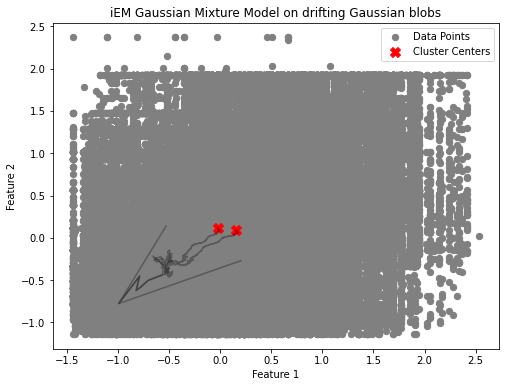

In [ ]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, label='Data Points')
history_mu_b = np.array(history_mu)
for k in range(n_components):
    plt.plot(history_mu_b[:, k, 0], history_mu_b[:, k, 1], 'k-', alpha=0.3)
plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
plt.title('iEM Gaussian Mixture Model on drifting Gaussian blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:

from scipy.stats import multivariate_normal
def initialize_parameters(n_components, n_features, first_points=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize mixing coefficients
    pi = np.ones(n_components) / n_components
    
    # Initialize means with more spread
    if first_points is not None:
        mu_k = first_points + np.random.randn(n_components, n_features) * 2.0
    else:
        mu_k = np.random.randn(n_components, n_features) * 5.0
    
    # Initialize with larger covariances
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k) 
        for k in range(n_components)
    ])
    
    return pi, mu_k, sigma_k

def compute_responsibility(x_i, pi, mu_k, sigma_k):
    n_components = len(pi)
    probs = np.zeros(n_components)
    
    # Calculate squared distances to each center
    distances = np.array([np.sum((x_i - mu_k[k])**2) for k in range(n_components)])
    
    for k in range(n_components):
        try:
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
        except np.linalg.LinAlgError:
            sigma_k[k] = np.eye(len(x_i)) * np.trace(sigma_k[k]) / len(x_i)
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
    
    # Add small constant for numerical stability
    probs += 1e-10
    
    # Calculate initial responsibilities
    gamma = probs / probs.sum()
    
    # # Distance-based weighting
    # max_dist = np.max(distances)
    # distance_weights = 1.0 / (1.0 + distances/max_dist)
    # gamma = gamma * distance_weights
    # gamma = gamma / gamma.sum()

    gamma = gamma ** 2
    gamma = gamma / gamma.sum()
    
    # Ensure no component gets too dominant
    if np.max(gamma) > 0.9:
        gamma = np.clip(gamma, 0.1, 0.9)
        gamma = gamma / gamma.sum()
    
    return gamma
    

def update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t):
    n_components = len(pi)
    n_features = len(x_i)
    min_covar = 1e-6
    
    # Update counts with momentum
    N_k = (1 - step_size) * N_k + step_size * gamma
    
    # Update mixing coefficients
    pi = N_k / N_k.sum()
    
    # Calculate distances to current point
    distances = np.array([np.sum((x_i - mu_k[k])**2) for k in range(n_components)])
    max_dist = np.max(distances)
    
    # Update means with distance-weighted learning rates
    for k in range(n_components):
        delta = x_i - mu_k[k]
        
        # Distance-based learning rate adjustment
        distance_factor = 1.0 / (1.0 + distances[k]/max_dist)
        effective_rate = step_size * distance_factor
        
        # Only update if the responsibility is significant
        if gamma[k] > 0.1:
            mu_k[k] += effective_rate * gamma[k] * delta
    
    # Update covariances
    for k in range(n_components):
        delta = x_i - mu_k[k]
        delta_out = np.outer(delta, delta)
        
        # Use same distance-based learning rate
        distance_factor = 1.0 / (1.0 + distances[k]/max_dist)
        effective_rate = step_size * distance_factor
        
        if gamma[k] > 0.1:
            sigma_k[k] = (1 - effective_rate) * sigma_k[k] + \
                         effective_rate * gamma[k] * delta_out
            
            # Ensure positive definiteness
            sigma_k[k] = (sigma_k[k] + sigma_k[k].T) / 2
            eigvals, eigvecs = np.linalg.eigh(sigma_k[k])
            eigvals = np.maximum(eigvals, min_covar)
            sigma_k[k] = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    return pi, mu_k, sigma_k, N_k

# stepwise EM
def online_gmm(data_generator, n_components, n_features, n_iterations, alpha=0.6, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Collect first few points for initialization
    first_points = np.array([next(data_generator) for _ in range(n_components)])
    # first_points = None  # Disable initialization with first points

    # Initialize parameters
    pi, mu_k, sigma_k = initialize_parameters(n_components, n_features, first_points, random_state)
    N_k = np.ones(n_components) / n_components
    
    # Store history for visualization
    history_mu = []
    
    # Process data points one at a time
    for t in range(n_iterations):
        x_i = next(data_generator)
        
        # Adaptive step size with slower decay
        step_size = (t + 2) ** -alpha
        
        # E-step: Compute responsibilities
        gamma = compute_responsibility(x_i, pi, mu_k, sigma_k)
        
        # M-step: Update parameters
        pi, mu_k, sigma_k, N_k = update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t)
        
        # Store current means
        history_mu.append(mu_k.copy())
        
        if t % 50 == 0:
            if np.max(N_k) > 0.8 or np.min(N_k) < 0.2:
                # Reset mixing coefficients
                N_k = np.ones(n_components) / n_components
                pi = N_k.copy()
    
    return pi, mu_k, sigma_k, history_mu

def data_generator(X):
    idx = 0
    n_samples = len(X)
    while idx < n_samples:
        yield X[idx]
        idx += 1


In [ ]:
X = loan_data
X = X.astype(float)
X = X[:-1000]
n_components = 2
n_features = 2
n_samples = len(X)
alpha = 0.6
random_state = 42
n_iterations = n_samples - n_components

gen = data_generator(X)
pi, mu_k, sigma_k, history_mu = online_gmm(gen, n_components, n_features, 
                                            n_iterations, alpha, random_state)

pi_step, mu_k_step, sigma_k_step, history_mu_step = pi, mu_k, sigma_k, history_mu

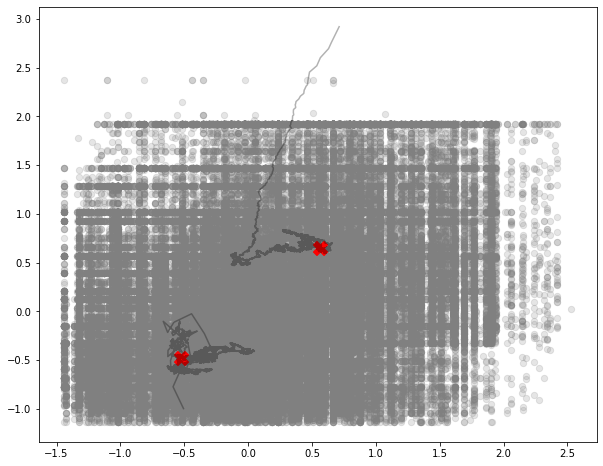

In [ ]:
plt.figure(figsize=(10, 8))

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, alpha=0.2, label='Data Points')

# Plot final cluster centers
plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=200, marker='X', label='Final Centers')

# Plot center trajectories
history_mu = np.array(history_mu)
for k in range(n_components):
    plt.plot(history_mu[:, k, 0], history_mu[:, k, 1], 'k-', alpha=0.3)

In [ ]:
import numpy as np

def calculate_log_likelihood(data, mu_k, sigma_k, pi_k):
    """
    Calculate the log-likelihood of data under a Gaussian Mixture Model.

    Parameters:
    - data: numpy array of shape (n_samples, n_features), the input data.
    - mu_k: numpy array of shape (n_components, n_features), the means of the components.
    - sigma_k: numpy array of shape (n_components, n_features, n_features), the covariance matrices.
    - pi_k: numpy array of shape (n_components,), the mixture weights. Assumes weights sum to 1.

    Returns:
    - log_likelihood: float, the log-likelihood of the entire dataset.
    """
    n_samples, n_features = data.shape
    n_components = mu_k.shape[0]

    # Initialize log-likelihood for all samples
    log_likelihood = 0.0

    for i in range(n_samples):
        sample_likelihood = 0.0

        for k in range(n_components):
            # Mean and covariance for component k
            mean = mu_k[k]
            cov = sigma_k[k]

            # Calculate the determinant and inverse of the covariance matrix
            det_cov = np.linalg.det(cov)
            inv_cov = np.linalg.inv(cov)

            # Gaussian PDF for component k
            norm_const = 1 / np.sqrt((2 * np.pi) ** n_features * det_cov)
            diff = data[i] - mean
            pdf_k = norm_const * np.exp(-0.5 * diff @ inv_cov @ diff)

            # Weighted PDF for component k
            sample_likelihood += pi_k[k] * pdf_k

        # Add log of sample likelihood to the total log-likelihood
        log_likelihood += np.log(sample_likelihood)

    return log_likelihood 


In [ ]:

likelihood = calculate_likelihood(X, mu_k, sigma_k, pi_k=pi)

In [ ]:
loan_data = loan_data.astype(float)
likelihood_iem = calculate_log_likelihood(loan_data[-1000:], mu_k_iem, sigma_k_iem, pi_k=pi_iem)
likelihood_step = calculate_log_likelihood(loan_data[-1000:], mu_k_step, sigma_k_step, pi_k=pi_step)

print(f"Likelihood for Online Incremental EM: {likelihood_iem}")
print(f"Likelihood for Stepwise EM: {likelihood_step}")

Likelihood for Online Incremental EM: -2448.484364073687
Likelihood for Stepwise EM: -2308.292892027893
